## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("./scaled_dataset.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max,building_id
0,0.8,143.0,210,1.72,218.0,94.6,0.434,6.255319,7,61.340426,...,1031.902128,1030.8,1034.5,256.340426,227,312,5.036170,2.2,7.4,1
1,16.9,143.0,210,1.72,218.0,94.6,0.434,3.375000,5,59.520833,...,1034.843750,1031.6,1038.1,317.437500,294,339,6.245833,2.0,7.6,1
2,1.4,143.0,210,1.72,218.0,94.6,0.434,-0.666667,2,59.916667,...,1038.256250,1037.5,1039.3,290.979167,211,345,2.154167,1.1,3.5,1
3,6.6,143.0,210,1.72,218.0,94.6,0.434,1.083333,3,63.166667,...,1037.075000,1035.6,1038.6,227.041667,2,359,2.637500,0.6,4.6,1
4,0.3,143.0,210,1.72,218.0,94.6,0.434,2.479167,4,60.812500,...,1032.722917,1031.7,1035.6,259.770833,236,287,5.212500,3.7,6.2,1


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((10847, 24, 35), (10847,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8696, 24, 35), (8696,), (1087, 24, 35), (1087,), (1064, 24, 35), (1064,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

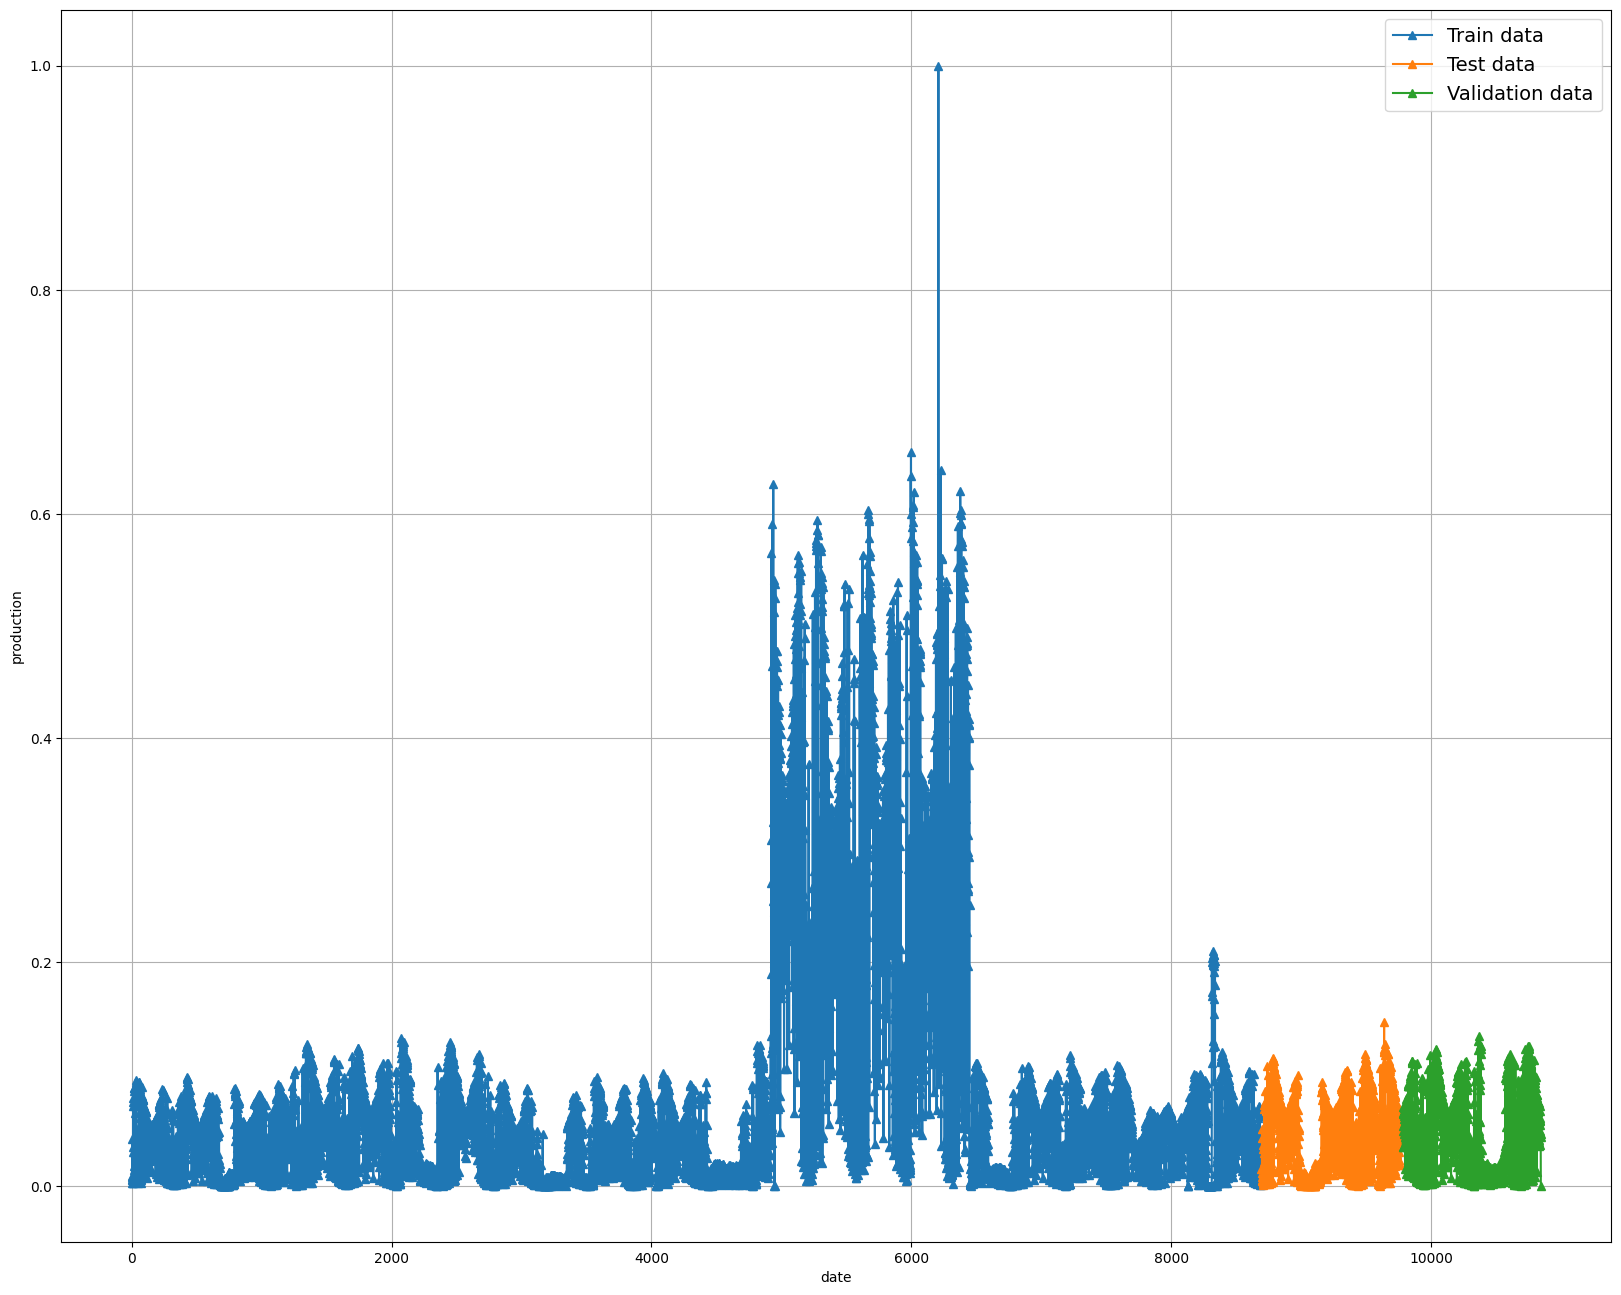

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(8696, 24, 35) -> (8696, 24, 1, 35)


In [17]:
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense

# Hyperparamètres optimisés
filters = 64
kernel_size = 1
activation = 'relu'
dense_units = 128
learning_rate = 0.0036909175284319386

tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=False),
    Flatten(),
    Dense(units=dense_units, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
)

conv_lstm_model.summary()


Model: "model_conv_lstm.keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 24, 1, 64)         25600     
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 1, 64)             33024     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67073 (262.00 KB)
Trainable params: 67073 (262.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 11:56:25] [setup] RAM Tracking...
[codecarbon INFO @ 11:56:25] [setup] CPU Tracking...
[codecarbon WARNING @ 11:56:25] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 11:56:27] We saw that you have a 12th Gen Intel(R) Core(TM) i7-12700H but we don't know it. Please contact us.
[codecarbon INFO @ 11:56:27] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 11:56:27] [setup] GPU Tracking...
[codecarbon INFO @ 11:56:28] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:56:28] >>> Tracker's metadata:
[codecarbon INFO @ 11:56:28]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 11:56:28]   Python version: 3.11.3
[codecarbon INFO @ 11:56:28]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 11:56:28]   Available RAM : 31.711 GB
[codecarbon INFO @ 11:56:28]   CPU count: 20
[codecarbon INFO @ 11:56:28]   CPU

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [20]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300



[codecarbon INFO @ 11:56:38] Energy consumed for RAM : 0.000033 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:56:38] Energy consumed for all CPUs : 0.000118 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:56:40] Energy consumed for all GPUs : 0.000005 kWh. Total GPU Power : 1.9047691432083536 W
[codecarbon INFO @ 11:56:40] 0.000157 kWh of electricity used since the beginning.


17/17 [==============================] - 18s 311ms/step - loss: 0.0559 - val_loss: 0.0288
Epoch 2/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0420

[codecarbon INFO @ 11:56:48] Energy consumed for RAM : 0.000062 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:56:48] Energy consumed for all CPUs : 0.000220 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 178ms/step - loss: 0.0418 - val_loss: 0.0295
Epoch 3/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0419

[codecarbon INFO @ 11:56:50] Energy consumed for all GPUs : 0.000015 kWh. Total GPU Power : 3.956012516882399 W
[codecarbon INFO @ 11:56:50] 0.000297 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 176ms/step - loss: 0.0395 - val_loss: 0.0278
Epoch 4/300
17/17 [==============================] - 3s 182ms/step - loss: 0.0389 - val_loss: 0.0281
Epoch 5/300
17/17 [==============================] - 3s 189ms/step - loss: 0.0378 - val_loss: 0.0269
Epoch 6/300


[codecarbon INFO @ 11:56:58] Energy consumed for RAM : 0.000090 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:56:58] Energy consumed for all CPUs : 0.000322 kWh. Total CPU Power : 42.5 W


10/17 [================>.............] - ETA: 1s - loss: 0.0366

[codecarbon INFO @ 11:57:00] Energy consumed for all GPUs : 0.000025 kWh. Total GPU Power : 4.1170244776920155 W
[codecarbon INFO @ 11:57:00] 0.000437 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 165ms/step - loss: 0.0367 - val_loss: 0.0265
Epoch 7/300
17/17 [==============================] - 3s 186ms/step - loss: 0.0367 - val_loss: 0.0261
Epoch 8/300
17/17 [==============================] - 3s 189ms/step - loss: 0.0367 - val_loss: 0.0259
Epoch 9/300
 5/17 [=======>......................] - ETA: 2s - loss: 0.0345

[codecarbon INFO @ 11:57:08] Energy consumed for RAM : 0.000118 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:57:08] Energy consumed for all CPUs : 0.000424 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0354

[codecarbon INFO @ 11:57:10] Energy consumed for all GPUs : 0.000035 kWh. Total GPU Power : 4.292482849570157 W
[codecarbon INFO @ 11:57:10] 0.000577 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 158ms/step - loss: 0.0353 - val_loss: 0.0262
Epoch 10/300
17/17 [==============================] - 3s 183ms/step - loss: 0.0347 - val_loss: 0.0252
Epoch 11/300
17/17 [==============================] - 3s 184ms/step - loss: 0.0343 - val_loss: 0.0259
Epoch 12/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0352

[codecarbon INFO @ 11:57:18] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:57:18] Energy consumed for all CPUs : 0.000525 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 175ms/step - loss: 0.0345 - val_loss: 0.0242
Epoch 13/300
 3/17 [====>.........................] - ETA: 2s - loss: 0.0325

[codecarbon INFO @ 11:57:20] Energy consumed for all GPUs : 0.000046 kWh. Total GPU Power : 4.674633854770611 W
[codecarbon INFO @ 11:57:20] 0.000718 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 171ms/step - loss: 0.0339 - val_loss: 0.0251
Epoch 14/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0341 - val_loss: 0.0278
Epoch 15/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0343 - val_loss: 0.0255
Epoch 16/300
 1/17 [>.............................] - ETA: 3s - loss: 0.0321

[codecarbon INFO @ 11:57:28] Energy consumed for RAM : 0.000175 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:57:28] Energy consumed for all CPUs : 0.000627 kWh. Total CPU Power : 42.5 W


11/17 [==================>...........] - ETA: 0s - loss: 0.0343

[codecarbon INFO @ 11:57:30] Energy consumed for all GPUs : 0.000056 kWh. Total GPU Power : 4.250515304487701 W
[codecarbon INFO @ 11:57:30] 0.000858 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 160ms/step - loss: 0.0341 - val_loss: 0.0238
Epoch 17/300
17/17 [==============================] - 3s 180ms/step - loss: 0.0341 - val_loss: 0.0237
Epoch 18/300
17/17 [==============================] - 3s 176ms/step - loss: 0.0342 - val_loss: 0.0244
Epoch 19/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0336

[codecarbon INFO @ 11:57:38] Energy consumed for RAM : 0.000203 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:57:38] Energy consumed for all CPUs : 0.000729 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 165ms/step - loss: 0.0330 - val_loss: 0.0232
Epoch 20/300


[codecarbon INFO @ 11:57:40] Energy consumed for all GPUs : 0.000067 kWh. Total GPU Power : 4.5515433468510365 W
[codecarbon INFO @ 11:57:40] 0.000999 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 172ms/step - loss: 0.0336 - val_loss: 0.0236
Epoch 21/300
17/17 [==============================] - 3s 181ms/step - loss: 0.0330 - val_loss: 0.0225
Epoch 22/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0318

[codecarbon INFO @ 11:57:48] Energy consumed for RAM : 0.000232 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:57:48] Energy consumed for all CPUs : 0.000831 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 179ms/step - loss: 0.0318 - val_loss: 0.0217
Epoch 23/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0320

[codecarbon INFO @ 11:57:50] Energy consumed for all GPUs : 0.000077 kWh. Total GPU Power : 4.278544805672557 W
[codecarbon INFO @ 11:57:50] 0.001140 kWh of electricity used since the beginning.


 8/17 [=============>................] - ETA: 1s - loss: 0.0322

[codecarbon INFO @ 11:57:50] 0.000280 g.CO2eq/s mean an estimation of 8.822478780393244 kg.CO2eq/year


17/17 [==============================] - 3s 162ms/step - loss: 0.0324 - val_loss: 0.0225
Epoch 24/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0320 - val_loss: 0.0227
Epoch 25/300
17/17 [==============================] - 3s 178ms/step - loss: 0.0318 - val_loss: 0.0216
Epoch 26/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0315

[codecarbon INFO @ 11:57:58] Energy consumed for RAM : 0.000260 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:57:58] Energy consumed for all CPUs : 0.000932 kWh. Total CPU Power : 42.5 W


16/17 [===========================>..] - ETA: 0s - loss: 0.0312

[codecarbon INFO @ 11:58:00] Energy consumed for all GPUs : 0.000088 kWh. Total GPU Power : 4.278840571135226 W
[codecarbon INFO @ 11:58:00] 0.001280 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 158ms/step - loss: 0.0312 - val_loss: 0.0249
Epoch 27/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0309 - val_loss: 0.0226
Epoch 28/300
17/17 [==============================] - 3s 178ms/step - loss: 0.0313 - val_loss: 0.0206
Epoch 29/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0308

[codecarbon INFO @ 11:58:08] Energy consumed for RAM : 0.000289 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:58:08] Energy consumed for all CPUs : 0.001034 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 169ms/step - loss: 0.0307 - val_loss: 0.0205
Epoch 30/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0298

[codecarbon INFO @ 11:58:10] Energy consumed for all GPUs : 0.000098 kWh. Total GPU Power : 4.1986380085030435 W
[codecarbon INFO @ 11:58:10] 0.001420 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 157ms/step - loss: 0.0308 - val_loss: 0.0220
Epoch 31/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0303 - val_loss: 0.0193
Epoch 32/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0309 - val_loss: 0.0208
Epoch 33/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0322

[codecarbon INFO @ 11:58:18] Energy consumed for RAM : 0.000317 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:58:18] Energy consumed for all CPUs : 0.001136 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0308

[codecarbon INFO @ 11:58:20] Energy consumed for all GPUs : 0.000108 kWh. Total GPU Power : 4.208664843457482 W
[codecarbon INFO @ 11:58:20] 0.001561 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 155ms/step - loss: 0.0308 - val_loss: 0.0200
Epoch 34/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0312 - val_loss: 0.0266
Epoch 35/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0313 - val_loss: 0.0205
Epoch 36/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0295 - val_loss: 0.0202


[codecarbon INFO @ 11:58:28] Energy consumed for RAM : 0.000345 kWh. RAM Power : 11.891499996185303 W


Epoch 37/300


[codecarbon INFO @ 11:58:29] Energy consumed for all CPUs : 0.001238 kWh. Total CPU Power : 42.5 W


10/17 [================>.............] - ETA: 0s - loss: 0.0295

[codecarbon INFO @ 11:58:30] Energy consumed for all GPUs : 0.000118 kWh. Total GPU Power : 4.213408524485779 W
[codecarbon INFO @ 11:58:30] 0.001701 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 157ms/step - loss: 0.0294 - val_loss: 0.0187
Epoch 38/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0291 - val_loss: 0.0193
Epoch 39/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0293 - val_loss: 0.0189
Epoch 40/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0292

[codecarbon INFO @ 11:58:39] Energy consumed for RAM : 0.000374 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:58:39] Energy consumed for all CPUs : 0.001339 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 161ms/step - loss: 0.0298 - val_loss: 0.0188
Epoch 41/300


[codecarbon INFO @ 11:58:40] Energy consumed for all GPUs : 0.000128 kWh. Total GPU Power : 4.295438424886043 W
[codecarbon INFO @ 11:58:40] 0.001841 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 174ms/step - loss: 0.0284 - val_loss: 0.0182
Epoch 42/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0291 - val_loss: 0.0189
Epoch 43/300
17/17 [==============================] - ETA: 0s - loss: 0.0289

[codecarbon INFO @ 11:58:49] Energy consumed for RAM : 0.000402 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:58:49] Energy consumed for all CPUs : 0.001441 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 173ms/step - loss: 0.0289 - val_loss: 0.0213
Epoch 44/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0300

[codecarbon INFO @ 11:58:50] Energy consumed for all GPUs : 0.000138 kWh. Total GPU Power : 4.298028002074936 W
[codecarbon INFO @ 11:58:50] 0.001981 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 155ms/step - loss: 0.0291 - val_loss: 0.0182
Epoch 45/300
17/17 [==============================] - 3s 178ms/step - loss: 0.0284 - val_loss: 0.0181
Epoch 46/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0284 - val_loss: 0.0182
Epoch 47/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0277

[codecarbon INFO @ 11:58:59] Energy consumed for RAM : 0.000430 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:58:59] Energy consumed for all CPUs : 0.001543 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 160ms/step - loss: 0.0281 - val_loss: 0.0183
Epoch 48/300


[codecarbon INFO @ 11:59:00] Energy consumed for all GPUs : 0.000149 kWh. Total GPU Power : 4.260628225720092 W
[codecarbon INFO @ 11:59:00] 0.002122 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 171ms/step - loss: 0.0287 - val_loss: 0.0174
Epoch 49/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0286 - val_loss: 0.0192
Epoch 50/300
17/17 [==============================] - ETA: 0s - loss: 0.0283

[codecarbon INFO @ 11:59:09] Energy consumed for RAM : 0.000459 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:59:09] Energy consumed for all CPUs : 0.001645 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 171ms/step - loss: 0.0283 - val_loss: 0.0184
Epoch 51/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0274

[codecarbon INFO @ 11:59:10] Energy consumed for all GPUs : 0.000160 kWh. Total GPU Power : 4.88019146029183 W
[codecarbon INFO @ 11:59:10] 0.002264 kWh of electricity used since the beginning.


11/17 [==================>...........] - ETA: 0s - loss: 0.0272

[codecarbon INFO @ 11:59:10] 0.000281 g.CO2eq/s mean an estimation of 8.850939643535455 kg.CO2eq/year


17/17 [==============================] - 3s 150ms/step - loss: 0.0280 - val_loss: 0.0204
Epoch 52/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0276 - val_loss: 0.0172
Epoch 53/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0276 - val_loss: 0.0174
Epoch 54/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0266

[codecarbon INFO @ 11:59:19] Energy consumed for RAM : 0.000487 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:59:19] Energy consumed for all CPUs : 0.001746 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 156ms/step - loss: 0.0277 - val_loss: 0.0181
Epoch 55/300
 1/17 [>.............................] - ETA: 3s - loss: 0.0256

[codecarbon INFO @ 11:59:20] Energy consumed for all GPUs : 0.000170 kWh. Total GPU Power : 4.022979556101589 W
[codecarbon INFO @ 11:59:20] 0.002404 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 166ms/step - loss: 0.0280 - val_loss: 0.0180
Epoch 56/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0270 - val_loss: 0.0173
Epoch 57/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0272 - val_loss: 0.0172
Epoch 58/300


[codecarbon INFO @ 11:59:29] Energy consumed for RAM : 0.000516 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:59:29] Energy consumed for all CPUs : 0.001848 kWh. Total CPU Power : 42.5 W


10/17 [================>.............] - ETA: 0s - loss: 0.0262

[codecarbon INFO @ 11:59:30] Energy consumed for all GPUs : 0.000180 kWh. Total GPU Power : 4.275137169177841 W
[codecarbon INFO @ 11:59:30] 0.002544 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 150ms/step - loss: 0.0270 - val_loss: 0.0172
Epoch 59/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0269 - val_loss: 0.0175
Epoch 60/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0268 - val_loss: 0.0181
Epoch 61/300
10/17 [================>.............] - ETA: 1s - loss: 0.0265

[codecarbon INFO @ 11:59:39] Energy consumed for RAM : 0.000544 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:59:39] Energy consumed for all CPUs : 0.001950 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 164ms/step - loss: 0.0266 - val_loss: 0.0169
Epoch 62/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0227

[codecarbon INFO @ 11:59:40] Energy consumed for all GPUs : 0.000191 kWh. Total GPU Power : 4.600047720024329 W
[codecarbon INFO @ 11:59:40] 0.002685 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 167ms/step - loss: 0.0269 - val_loss: 0.0170
Epoch 63/300
17/17 [==============================] - 3s 177ms/step - loss: 0.0268 - val_loss: 0.0182
Epoch 64/300
17/17 [==============================] - ETA: 0s - loss: 0.0269

[codecarbon INFO @ 11:59:49] Energy consumed for RAM : 0.000572 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 11:59:49] Energy consumed for all CPUs : 0.002051 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 179ms/step - loss: 0.0269 - val_loss: 0.0165
Epoch 65/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0273

[codecarbon INFO @ 11:59:50] Energy consumed for all GPUs : 0.000201 kWh. Total GPU Power : 4.285866925480915 W
[codecarbon INFO @ 11:59:50] 0.002825 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 155ms/step - loss: 0.0264 - val_loss: 0.0167
Epoch 66/300
17/17 [==============================] - 3s 180ms/step - loss: 0.0261 - val_loss: 0.0164
Epoch 67/300
17/17 [==============================] - 3s 176ms/step - loss: 0.0260 - val_loss: 0.0163
Epoch 68/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0258

[codecarbon INFO @ 11:59:59] Energy consumed for RAM : 0.000601 kWh. RAM Power : 11.891499996185303 W


 8/17 [=============>................] - ETA: 1s - loss: 0.0254

[codecarbon INFO @ 11:59:59] Energy consumed for all CPUs : 0.002153 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0260

[codecarbon INFO @ 12:00:00] Energy consumed for all GPUs : 0.000212 kWh. Total GPU Power : 4.307808226130433 W
[codecarbon INFO @ 12:00:00] 0.002966 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 161ms/step - loss: 0.0260 - val_loss: 0.0165
Epoch 69/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0263 - val_loss: 0.0168
Epoch 70/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0260 - val_loss: 0.0164
Epoch 71/300
17/17 [==============================] - ETA: 0s - loss: 0.0258

[codecarbon INFO @ 12:00:09] Energy consumed for RAM : 0.000629 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:00:09] Energy consumed for all CPUs : 0.002255 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 171ms/step - loss: 0.0258 - val_loss: 0.0170
Epoch 72/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0258

[codecarbon INFO @ 12:00:10] Energy consumed for all GPUs : 0.000223 kWh. Total GPU Power : 4.613632398783085 W
[codecarbon INFO @ 12:00:10] 0.003107 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 159ms/step - loss: 0.0259 - val_loss: 0.0157
Epoch 73/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0265 - val_loss: 0.0162
Epoch 74/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0253 - val_loss: 0.0161
Epoch 75/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0256

[codecarbon INFO @ 12:00:19] Energy consumed for RAM : 0.000658 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:00:19] Energy consumed for all CPUs : 0.002356 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 160ms/step - loss: 0.0251 - val_loss: 0.0157
Epoch 76/300


[codecarbon INFO @ 12:00:20] Energy consumed for all GPUs : 0.000233 kWh. Total GPU Power : 4.310003786194158 W
[codecarbon INFO @ 12:00:20] 0.003247 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 138ms/step - loss: 0.0264 - val_loss: 0.0157
Epoch 77/300
17/17 [==============================] - 3s 146ms/step - loss: 0.0250 - val_loss: 0.0162
Epoch 78/300
17/17 [==============================] - 3s 159ms/step - loss: 0.0252 - val_loss: 0.0167
Epoch 79/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0241

[codecarbon INFO @ 12:00:29] Energy consumed for RAM : 0.000686 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:00:29] Energy consumed for all CPUs : 0.002459 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0248

[codecarbon INFO @ 12:00:30] Energy consumed for all GPUs : 0.000243 kWh. Total GPU Power : 4.296060546199245 W
[codecarbon INFO @ 12:00:30] 0.003388 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 156ms/step - loss: 0.0248 - val_loss: 0.0154
Epoch 80/300


[codecarbon INFO @ 12:00:30] 0.000450 g.CO2eq/s mean an estimation of 14.191038291164656 kg.CO2eq/year


17/17 [==============================] - 3s 161ms/step - loss: 0.0253 - val_loss: 0.0159
Epoch 81/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0248 - val_loss: 0.0151
Epoch 82/300
17/17 [==============================] - 3s 163ms/step - loss: 0.0249 - val_loss: 0.0158
Epoch 83/300


[codecarbon INFO @ 12:00:39] Energy consumed for RAM : 0.000714 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:00:39] Energy consumed for all CPUs : 0.002560 kWh. Total CPU Power : 42.5 W


11/17 [==================>...........] - ETA: 0s - loss: 0.0250

[codecarbon INFO @ 12:00:40] Energy consumed for all GPUs : 0.000254 kWh. Total GPU Power : 4.301873366490512 W
[codecarbon INFO @ 12:00:40] 0.003528 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 142ms/step - loss: 0.0246 - val_loss: 0.0152
Epoch 84/300
17/17 [==============================] - 2s 143ms/step - loss: 0.0248 - val_loss: 0.0180
Epoch 85/300
17/17 [==============================] - 3s 150ms/step - loss: 0.0249 - val_loss: 0.0169
Epoch 86/300
17/17 [==============================] - 2s 138ms/step - loss: 0.0246 - val_loss: 0.0156
Epoch 87/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0248

[codecarbon INFO @ 12:00:49] Energy consumed for RAM : 0.000743 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:00:49] Energy consumed for all CPUs : 0.002662 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0243

[codecarbon INFO @ 12:00:50] Energy consumed for all GPUs : 0.000264 kWh. Total GPU Power : 4.279702699264099 W
[codecarbon INFO @ 12:00:50] 0.003669 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 133ms/step - loss: 0.0243 - val_loss: 0.0151
Epoch 88/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0241 - val_loss: 0.0154
Epoch 89/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0238 - val_loss: 0.0153
Epoch 90/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0241

[codecarbon INFO @ 12:00:59] Energy consumed for RAM : 0.000771 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:00:59] Energy consumed for all CPUs : 0.002764 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 169ms/step - loss: 0.0241 - val_loss: 0.0169
Epoch 91/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0227

[codecarbon INFO @ 12:01:00] Energy consumed for all GPUs : 0.000274 kWh. Total GPU Power : 4.212652932695396 W
[codecarbon INFO @ 12:01:00] 0.003809 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 164ms/step - loss: 0.0235 - val_loss: 0.0148
Epoch 92/300
17/17 [==============================] - 3s 178ms/step - loss: 0.0232 - val_loss: 0.0148
Epoch 93/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0233 - val_loss: 0.0146
Epoch 94/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0234

[codecarbon INFO @ 12:01:09] Energy consumed for RAM : 0.000799 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:01:09] Energy consumed for all CPUs : 0.002865 kWh. Total CPU Power : 42.5 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0228

[codecarbon INFO @ 12:01:10] Energy consumed for all GPUs : 0.000284 kWh. Total GPU Power : 4.286817976738819 W
[codecarbon INFO @ 12:01:10] 0.003949 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 151ms/step - loss: 0.0230 - val_loss: 0.0150
Epoch 95/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0233 - val_loss: 0.0147
Epoch 96/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0228 - val_loss: 0.0150
Epoch 97/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0223

[codecarbon INFO @ 12:01:19] Energy consumed for RAM : 0.000828 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:01:19] Energy consumed for all CPUs : 0.002967 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 170ms/step - loss: 0.0222 - val_loss: 0.0141
Epoch 98/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0231

[codecarbon INFO @ 12:01:20] Energy consumed for all GPUs : 0.000295 kWh. Total GPU Power : 4.30827894846026 W
[codecarbon INFO @ 12:01:20] 0.004090 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 161ms/step - loss: 0.0229 - val_loss: 0.0148
Epoch 99/300
17/17 [==============================] - 3s 177ms/step - loss: 0.0223 - val_loss: 0.0144
Epoch 100/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0222 - val_loss: 0.0150
Epoch 101/300
 3/17 [====>.........................] - ETA: 2s - loss: 0.0214

[codecarbon INFO @ 12:01:29] Energy consumed for RAM : 0.000856 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:01:29] Energy consumed for all CPUs : 0.003069 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0221

[codecarbon INFO @ 12:01:30] Energy consumed for all GPUs : 0.000305 kWh. Total GPU Power : 4.2903922695482795 W
[codecarbon INFO @ 12:01:30] 0.004230 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 142ms/step - loss: 0.0221 - val_loss: 0.0150
Epoch 102/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0221 - val_loss: 0.0143
Epoch 103/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0220 - val_loss: 0.0143
Epoch 104/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0223

[codecarbon INFO @ 12:01:39] Energy consumed for RAM : 0.000885 kWh. RAM Power : 11.891499996185303 W


16/17 [===========================>..] - ETA: 0s - loss: 0.0223

[codecarbon INFO @ 12:01:39] Energy consumed for all CPUs : 0.003170 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 170ms/step - loss: 0.0225 - val_loss: 0.0144
Epoch 105/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0219

[codecarbon INFO @ 12:01:40] Energy consumed for all GPUs : 0.000315 kWh. Total GPU Power : 4.290852794770097 W
[codecarbon INFO @ 12:01:40] 0.004370 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 147ms/step - loss: 0.0220 - val_loss: 0.0139
Epoch 106/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0217 - val_loss: 0.0149
Epoch 107/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0216 - val_loss: 0.0143
Epoch 108/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0226

[codecarbon INFO @ 12:01:49] Energy consumed for RAM : 0.000913 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:01:49] Energy consumed for all CPUs : 0.003272 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0216

[codecarbon INFO @ 12:01:50] Energy consumed for all GPUs : 0.000325 kWh. Total GPU Power : 4.289881166089621 W
[codecarbon INFO @ 12:01:50] 0.004511 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 168ms/step - loss: 0.0216 - val_loss: 0.0130
Epoch 109/300


[codecarbon INFO @ 12:01:50] 0.000337 g.CO2eq/s mean an estimation of 10.613026041433145 kg.CO2eq/year


17/17 [==============================] - 3s 173ms/step - loss: 0.0213 - val_loss: 0.0134
Epoch 110/300
17/17 [==============================] - 3s 178ms/step - loss: 0.0212 - val_loss: 0.0142
Epoch 111/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0214

[codecarbon INFO @ 12:01:59] Energy consumed for RAM : 0.000941 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:01:59] Energy consumed for all CPUs : 0.003374 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 173ms/step - loss: 0.0213 - val_loss: 0.0147
Epoch 112/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0204

[codecarbon INFO @ 12:02:00] Energy consumed for all GPUs : 0.000336 kWh. Total GPU Power : 4.2770253493940595 W
[codecarbon INFO @ 12:02:00] 0.004651 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 124ms/step - loss: 0.0211 - val_loss: 0.0135
Epoch 113/300
17/17 [==============================] - 2s 138ms/step - loss: 0.0207 - val_loss: 0.0139
Epoch 114/300
17/17 [==============================] - 3s 156ms/step - loss: 0.0216 - val_loss: 0.0142
Epoch 115/300
17/17 [==============================] - 2s 144ms/step - loss: 0.0206 - val_loss: 0.0133
Epoch 116/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0217

[codecarbon INFO @ 12:02:09] Energy consumed for RAM : 0.000970 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:02:09] Energy consumed for all CPUs : 0.003476 kWh. Total CPU Power : 42.5 W


11/17 [==================>...........] - ETA: 0s - loss: 0.0212

[codecarbon INFO @ 12:02:10] Energy consumed for all GPUs : 0.000346 kWh. Total GPU Power : 4.27995580728198 W
[codecarbon INFO @ 12:02:10] 0.004792 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 144ms/step - loss: 0.0212 - val_loss: 0.0135
Epoch 117/300
17/17 [==============================] - 3s 151ms/step - loss: 0.0208 - val_loss: 0.0152
Epoch 118/300
17/17 [==============================] - 3s 157ms/step - loss: 0.0212 - val_loss: 0.0133
Epoch 119/300
17/17 [==============================] - ETA: 0s - loss: 0.0216

[codecarbon INFO @ 12:02:19] Energy consumed for RAM : 0.000998 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:02:19] Energy consumed for all CPUs : 0.003578 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 148ms/step - loss: 0.0216 - val_loss: 0.0140
Epoch 120/300
10/17 [================>.............] - ETA: 0s - loss: 0.0209

[codecarbon INFO @ 12:02:20] Energy consumed for all GPUs : 0.000357 kWh. Total GPU Power : 4.562382926527343 W
[codecarbon INFO @ 12:02:20] 0.004933 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 146ms/step - loss: 0.0209 - val_loss: 0.0124
Epoch 121/300
17/17 [==============================] - 2s 136ms/step - loss: 0.0205 - val_loss: 0.0126
Epoch 122/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0196 - val_loss: 0.0133
Epoch 123/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0193

[codecarbon INFO @ 12:02:29] Energy consumed for RAM : 0.001027 kWh. RAM Power : 11.891499996185303 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0193

[codecarbon INFO @ 12:02:29] Energy consumed for all CPUs : 0.003680 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 171ms/step - loss: 0.0199 - val_loss: 0.0129
Epoch 124/300
 4/17 [======>.......................] - ETA: 2s - loss: 0.0200

[codecarbon INFO @ 12:02:30] Energy consumed for all GPUs : 0.000368 kWh. Total GPU Power : 4.818383169092134 W
[codecarbon INFO @ 12:02:30] 0.005075 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 160ms/step - loss: 0.0194 - val_loss: 0.0125
Epoch 125/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0195 - val_loss: 0.0146
Epoch 126/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0202 - val_loss: 0.0136
Epoch 127/300
 4/17 [======>.......................] - ETA: 2s - loss: 0.0187

[codecarbon INFO @ 12:02:39] Energy consumed for RAM : 0.001055 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:02:39] Energy consumed for all CPUs : 0.003781 kWh. Total CPU Power : 42.5 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0193

[codecarbon INFO @ 12:02:40] Energy consumed for all GPUs : 0.000379 kWh. Total GPU Power : 4.304786839935671 W
[codecarbon INFO @ 12:02:40] 0.005215 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 165ms/step - loss: 0.0195 - val_loss: 0.0123
Epoch 128/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0196 - val_loss: 0.0118
Epoch 129/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0190 - val_loss: 0.0118
Epoch 130/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0190

[codecarbon INFO @ 12:02:49] Energy consumed for RAM : 0.001083 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:02:49] Energy consumed for all CPUs : 0.003883 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 169ms/step - loss: 0.0190 - val_loss: 0.0124
Epoch 131/300
 3/17 [====>.........................] - ETA: 2s - loss: 0.0197

[codecarbon INFO @ 12:02:50] Energy consumed for all GPUs : 0.000389 kWh. Total GPU Power : 4.355192741054507 W
[codecarbon INFO @ 12:02:50] 0.005356 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 146ms/step - loss: 0.0192 - val_loss: 0.0135
Epoch 132/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0196 - val_loss: 0.0131
Epoch 133/300
17/17 [==============================] - 3s 162ms/step - loss: 0.0190 - val_loss: 0.0124
Epoch 134/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0185

[codecarbon INFO @ 12:02:59] Energy consumed for RAM : 0.001112 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:02:59] Energy consumed for all CPUs : 0.003985 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0203

[codecarbon INFO @ 12:03:00] Energy consumed for all GPUs : 0.000400 kWh. Total GPU Power : 4.613328164266057 W
[codecarbon INFO @ 12:03:00] 0.005497 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 149ms/step - loss: 0.0203 - val_loss: 0.0155
Epoch 135/300
17/17 [==============================] - 3s 163ms/step - loss: 0.0192 - val_loss: 0.0136
Epoch 136/300
17/17 [==============================] - 3s 176ms/step - loss: 0.0191 - val_loss: 0.0124
Epoch 137/300
17/17 [==============================] - ETA: 0s - loss: 0.0188

[codecarbon INFO @ 12:03:09] Energy consumed for RAM : 0.001140 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:03:09] Energy consumed for all CPUs : 0.004087 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 171ms/step - loss: 0.0188 - val_loss: 0.0125
Epoch 138/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0197

[codecarbon INFO @ 12:03:10] Energy consumed for all GPUs : 0.000410 kWh. Total GPU Power : 4.068990673362029 W
[codecarbon INFO @ 12:03:10] 0.005637 kWh of electricity used since the beginning.


10/17 [================>.............] - ETA: 0s - loss: 0.0198

[codecarbon INFO @ 12:03:10] 0.000337 g.CO2eq/s mean an estimation of 10.639214787892728 kg.CO2eq/year


17/17 [==============================] - 3s 154ms/step - loss: 0.0195 - val_loss: 0.0124
Epoch 139/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0186 - val_loss: 0.0132
Epoch 140/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0188 - val_loss: 0.0122
Epoch 141/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0176

[codecarbon INFO @ 12:03:19] Energy consumed for RAM : 0.001169 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:03:19] Energy consumed for all CPUs : 0.004188 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 167ms/step - loss: 0.0179 - val_loss: 0.0115
Epoch 142/300


[codecarbon INFO @ 12:03:20] Energy consumed for all GPUs : 0.000420 kWh. Total GPU Power : 4.154137837427238 W


 1/17 [>.............................] - ETA: 2s - loss: 0.0165

[codecarbon INFO @ 12:03:20] 0.005777 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 155ms/step - loss: 0.0179 - val_loss: 0.0122
Epoch 143/300
17/17 [==============================] - 3s 184ms/step - loss: 0.0180 - val_loss: 0.0113
Epoch 144/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0185 - val_loss: 0.0121
Epoch 145/300


[codecarbon INFO @ 12:03:29] Energy consumed for RAM : 0.001197 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:03:29] Energy consumed for all CPUs : 0.004290 kWh. Total CPU Power : 42.5 W


11/17 [==================>...........] - ETA: 0s - loss: 0.0175

[codecarbon INFO @ 12:03:30] Energy consumed for all GPUs : 0.000430 kWh. Total GPU Power : 4.335759372953605 W
[codecarbon INFO @ 12:03:30] 0.005917 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 151ms/step - loss: 0.0173 - val_loss: 0.0116
Epoch 146/300
17/17 [==============================] - 3s 180ms/step - loss: 0.0176 - val_loss: 0.0114
Epoch 147/300
17/17 [==============================] - 3s 157ms/step - loss: 0.0176 - val_loss: 0.0134
Epoch 148/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0170

[codecarbon INFO @ 12:03:39] Energy consumed for RAM : 0.001225 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:03:39] Energy consumed for all CPUs : 0.004392 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 163ms/step - loss: 0.0174 - val_loss: 0.0114
Epoch 149/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0163

[codecarbon INFO @ 12:03:40] Energy consumed for all GPUs : 0.000440 kWh. Total GPU Power : 4.160076046580778 W
[codecarbon INFO @ 12:03:40] 0.006057 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 159ms/step - loss: 0.0175 - val_loss: 0.0119
Epoch 150/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0178 - val_loss: 0.0146
Epoch 151/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0177 - val_loss: 0.0114
Epoch 152/300
 2/17 [==>...........................] - ETA: 3s - loss: 0.0162

[codecarbon INFO @ 12:03:49] Energy consumed for RAM : 0.001254 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:03:49] Energy consumed for all CPUs : 0.004493 kWh. Total CPU Power : 42.5 W


13/17 [=====================>........] - ETA: 0s - loss: 0.0185

[codecarbon INFO @ 12:03:50] Energy consumed for all GPUs : 0.000450 kWh. Total GPU Power : 4.181147979073115 W
[codecarbon INFO @ 12:03:50] 0.006197 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 152ms/step - loss: 0.0182 - val_loss: 0.0118
Epoch 153/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0174 - val_loss: 0.0115
Epoch 154/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0168 - val_loss: 0.0111
Epoch 155/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0166

[codecarbon INFO @ 12:03:59] Energy consumed for RAM : 0.001282 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:03:59] Energy consumed for all CPUs : 0.004595 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 165ms/step - loss: 0.0169 - val_loss: 0.0111
Epoch 156/300
 3/17 [====>.........................] - ETA: 2s - loss: 0.0146

[codecarbon INFO @ 12:04:00] Energy consumed for all GPUs : 0.000460 kWh. Total GPU Power : 4.1587860603004545 W
[codecarbon INFO @ 12:04:00] 0.006337 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 163ms/step - loss: 0.0162 - val_loss: 0.0115
Epoch 157/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0168 - val_loss: 0.0113
Epoch 158/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0167 - val_loss: 0.0118
Epoch 159/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0165

[codecarbon INFO @ 12:04:09] Energy consumed for RAM : 0.001310 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:04:09] Energy consumed for all CPUs : 0.004697 kWh. Total CPU Power : 42.5 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0167

[codecarbon INFO @ 12:04:10] Energy consumed for all GPUs : 0.000470 kWh. Total GPU Power : 4.180517895318068 W
[codecarbon INFO @ 12:04:10] 0.006477 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 153ms/step - loss: 0.0167 - val_loss: 0.0121
Epoch 160/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0166 - val_loss: 0.0114
Epoch 161/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0165 - val_loss: 0.0116
Epoch 162/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0162

[codecarbon INFO @ 12:04:19] Energy consumed for RAM : 0.001339 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:04:19] Energy consumed for all CPUs : 0.004798 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 167ms/step - loss: 0.0161 - val_loss: 0.0112
Epoch 163/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0160

[codecarbon INFO @ 12:04:20] Energy consumed for all GPUs : 0.000480 kWh. Total GPU Power : 4.041987109029356 W
[codecarbon INFO @ 12:04:20] 0.006617 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 168ms/step - loss: 0.0162 - val_loss: 0.0105
Epoch 164/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0161 - val_loss: 0.0106
Epoch 165/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0157 - val_loss: 0.0107
Epoch 166/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0151

[codecarbon INFO @ 12:04:29] Energy consumed for RAM : 0.001367 kWh. RAM Power : 11.891499996185303 W


 6/17 [=========>....................] - ETA: 1s - loss: 0.0151

[codecarbon INFO @ 12:04:29] Energy consumed for all CPUs : 0.004900 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0156

[codecarbon INFO @ 12:04:30] Energy consumed for all GPUs : 0.000490 kWh. Total GPU Power : 4.160579301005267 W
[codecarbon INFO @ 12:04:30] 0.006757 kWh of electricity used since the beginning.


17/17 [==============================] - ETA: 0s - loss: 0.0160

[codecarbon INFO @ 12:04:30] 0.000336 g.CO2eq/s mean an estimation of 10.587958902656645 kg.CO2eq/year


17/17 [==============================] - 3s 156ms/step - loss: 0.0160 - val_loss: 0.0108
Epoch 167/300
17/17 [==============================] - 3s 176ms/step - loss: 0.0157 - val_loss: 0.0113
Epoch 168/300
17/17 [==============================] - 3s 178ms/step - loss: 0.0158 - val_loss: 0.0105
Epoch 169/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0152

[codecarbon INFO @ 12:04:39] Energy consumed for RAM : 0.001396 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:04:39] Energy consumed for all CPUs : 0.005002 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 168ms/step - loss: 0.0155 - val_loss: 0.0108
Epoch 170/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0160

[codecarbon INFO @ 12:04:40] Energy consumed for all GPUs : 0.000500 kWh. Total GPU Power : 4.148956702135591 W
[codecarbon INFO @ 12:04:40] 0.006897 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 165ms/step - loss: 0.0165 - val_loss: 0.0119
Epoch 171/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0158 - val_loss: 0.0118
Epoch 172/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0155 - val_loss: 0.0113
Epoch 173/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0141

[codecarbon INFO @ 12:04:49] Energy consumed for RAM : 0.001424 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:04:49] Energy consumed for all CPUs : 0.005103 kWh. Total CPU Power : 42.5 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0151

[codecarbon INFO @ 12:04:50] Energy consumed for all GPUs : 0.000510 kWh. Total GPU Power : 4.205060216067757 W
[codecarbon INFO @ 12:04:50] 0.007037 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 151ms/step - loss: 0.0154 - val_loss: 0.0110
Epoch 174/300
17/17 [==============================] - 3s 177ms/step - loss: 0.0153 - val_loss: 0.0098
Epoch 175/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0145 - val_loss: 0.0102
Epoch 176/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0145

[codecarbon INFO @ 12:04:59] Energy consumed for RAM : 0.001452 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:04:59] Energy consumed for all CPUs : 0.005205 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 165ms/step - loss: 0.0145 - val_loss: 0.0101
Epoch 177/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0141

[codecarbon INFO @ 12:05:00] Energy consumed for all GPUs : 0.000521 kWh. Total GPU Power : 4.539263058253529 W
[codecarbon INFO @ 12:05:00] 0.007178 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 159ms/step - loss: 0.0146 - val_loss: 0.0107
Epoch 178/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0148 - val_loss: 0.0103
Epoch 179/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0146 - val_loss: 0.0102
Epoch 180/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0146

[codecarbon INFO @ 12:05:09] Energy consumed for RAM : 0.001481 kWh. RAM Power : 11.891499996185303 W


 6/17 [=========>....................] - ETA: 1s - loss: 0.0147

[codecarbon INFO @ 12:05:09] Energy consumed for all CPUs : 0.005307 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0144

[codecarbon INFO @ 12:05:10] Energy consumed for all GPUs : 0.000531 kWh. Total GPU Power : 4.149941969929252 W
[codecarbon INFO @ 12:05:10] 0.007318 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 159ms/step - loss: 0.0145 - val_loss: 0.0098
Epoch 181/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0142 - val_loss: 0.0101
Epoch 182/300
17/17 [==============================] - 3s 178ms/step - loss: 0.0142 - val_loss: 0.0097
Epoch 183/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0141

[codecarbon INFO @ 12:05:19] Energy consumed for RAM : 0.001509 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:05:19] Energy consumed for all CPUs : 0.005409 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 163ms/step - loss: 0.0142 - val_loss: 0.0110
Epoch 184/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0145

[codecarbon INFO @ 12:05:20] Energy consumed for all GPUs : 0.000541 kWh. Total GPU Power : 4.394799674242138 W
[codecarbon INFO @ 12:05:20] 0.007459 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 162ms/step - loss: 0.0142 - val_loss: 0.0098
Epoch 185/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0141 - val_loss: 0.0105
Epoch 186/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0136 - val_loss: 0.0099
Epoch 187/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0135

[codecarbon INFO @ 12:05:29] Energy consumed for RAM : 0.001538 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:05:29] Energy consumed for all CPUs : 0.005511 kWh. Total CPU Power : 42.5 W


16/17 [===========================>..] - ETA: 0s - loss: 0.0140

[codecarbon INFO @ 12:05:30] Energy consumed for all GPUs : 0.000552 kWh. Total GPU Power : 4.6159707350265755 W
[codecarbon INFO @ 12:05:30] 0.007600 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 157ms/step - loss: 0.0139 - val_loss: 0.0096
Epoch 188/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0138 - val_loss: 0.0097
Epoch 189/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0134 - val_loss: 0.0099
Epoch 190/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0135

[codecarbon INFO @ 12:05:39] Energy consumed for RAM : 0.001566 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:05:39] Energy consumed for all CPUs : 0.005612 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 162ms/step - loss: 0.0136 - val_loss: 0.0103
Epoch 191/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0145

[codecarbon INFO @ 12:05:40] Energy consumed for all GPUs : 0.000562 kWh. Total GPU Power : 4.059156334644593 W
[codecarbon INFO @ 12:05:40] 0.007740 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 163ms/step - loss: 0.0136 - val_loss: 0.0095
Epoch 192/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0129 - val_loss: 0.0096
Epoch 193/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0130 - val_loss: 0.0108
Epoch 194/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0130

[codecarbon INFO @ 12:05:49] Energy consumed for RAM : 0.001594 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:05:49] Energy consumed for all CPUs : 0.005714 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 142ms/step - loss: 0.0133 - val_loss: 0.0103
Epoch 195/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0139

[codecarbon INFO @ 12:05:50] Energy consumed for all GPUs : 0.000572 kWh. Total GPU Power : 4.163260301714717 W
[codecarbon INFO @ 12:05:50] 0.007880 kWh of electricity used since the beginning.


 2/17 [==>...........................] - ETA: 1s - loss: 0.0144

[codecarbon INFO @ 12:05:51] 0.000337 g.CO2eq/s mean an estimation of 10.613961099060916 kg.CO2eq/year


17/17 [==============================] - 3s 164ms/step - loss: 0.0147 - val_loss: 0.0099
Epoch 196/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0138 - val_loss: 0.0093
Epoch 197/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0136 - val_loss: 0.0098
Epoch 198/300


[codecarbon INFO @ 12:05:59] Energy consumed for RAM : 0.001623 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:05:59] Energy consumed for all CPUs : 0.005816 kWh. Total CPU Power : 42.5 W


11/17 [==================>...........] - ETA: 0s - loss: 0.0127

[codecarbon INFO @ 12:06:00] Energy consumed for all GPUs : 0.000582 kWh. Total GPU Power : 4.137760052056231 W
[codecarbon INFO @ 12:06:00] 0.008020 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 153ms/step - loss: 0.0130 - val_loss: 0.0093
Epoch 199/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0137 - val_loss: 0.0106
Epoch 200/300
17/17 [==============================] - 3s 177ms/step - loss: 0.0131 - val_loss: 0.0088
Epoch 201/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0124

[codecarbon INFO @ 12:06:09] Energy consumed for RAM : 0.001651 kWh. RAM Power : 11.891499996185303 W


10/17 [================>.............] - ETA: 1s - loss: 0.0121

[codecarbon INFO @ 12:06:09] Energy consumed for all CPUs : 0.005917 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 164ms/step - loss: 0.0122 - val_loss: 0.0097
Epoch 202/300


[codecarbon INFO @ 12:06:10] Energy consumed for all GPUs : 0.000592 kWh. Total GPU Power : 4.16850139548104 W
[codecarbon INFO @ 12:06:10] 0.008160 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 172ms/step - loss: 0.0129 - val_loss: 0.0090
Epoch 203/300
17/17 [==============================] - 3s 162ms/step - loss: 0.0131 - val_loss: 0.0099
Epoch 204/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0133 - val_loss: 0.0095
Epoch 205/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0112

[codecarbon INFO @ 12:06:19] Energy consumed for RAM : 0.001679 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:06:19] Energy consumed for all CPUs : 0.006019 kWh. Total CPU Power : 42.5 W


11/17 [==================>...........] - ETA: 0s - loss: 0.0130

[codecarbon INFO @ 12:06:20] Energy consumed for all GPUs : 0.000602 kWh. Total GPU Power : 4.167236244663484 W
[codecarbon INFO @ 12:06:20] 0.008300 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 156ms/step - loss: 0.0133 - val_loss: 0.0093
Epoch 206/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0129 - val_loss: 0.0102
Epoch 207/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0126 - val_loss: 0.0088
Epoch 208/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0124

[codecarbon INFO @ 12:06:29] Energy consumed for RAM : 0.001708 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:06:29] Energy consumed for all CPUs : 0.006121 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 164ms/step - loss: 0.0123 - val_loss: 0.0092
Epoch 209/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0115

[codecarbon INFO @ 12:06:30] Energy consumed for all GPUs : 0.000612 kWh. Total GPU Power : 4.149073691307161 W
[codecarbon INFO @ 12:06:30] 0.008440 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 161ms/step - loss: 0.0124 - val_loss: 0.0092
Epoch 210/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0124 - val_loss: 0.0093
Epoch 211/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0121 - val_loss: 0.0089
Epoch 212/300
 3/17 [====>.........................] - ETA: 2s - loss: 0.0117

[codecarbon INFO @ 12:06:39] Energy consumed for RAM : 0.001736 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:06:39] Energy consumed for all CPUs : 0.006223 kWh. Total CPU Power : 42.5 W


13/17 [=====================>........] - ETA: 0s - loss: 0.0115

[codecarbon INFO @ 12:06:40] Energy consumed for all GPUs : 0.000622 kWh. Total GPU Power : 4.169014614312825 W
[codecarbon INFO @ 12:06:40] 0.008581 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 156ms/step - loss: 0.0118 - val_loss: 0.0092
Epoch 213/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0120 - val_loss: 0.0094
Epoch 214/300
17/17 [==============================] - 3s 176ms/step - loss: 0.0117 - val_loss: 0.0088
Epoch 215/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0125

[codecarbon INFO @ 12:06:49] Energy consumed for RAM : 0.001765 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:06:49] Energy consumed for all CPUs : 0.006324 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 162ms/step - loss: 0.0124 - val_loss: 0.0098
Epoch 216/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0120

[codecarbon INFO @ 12:06:50] Energy consumed for all GPUs : 0.000632 kWh. Total GPU Power : 4.156374178747476 W
[codecarbon INFO @ 12:06:50] 0.008721 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 154ms/step - loss: 0.0126 - val_loss: 0.0092
Epoch 217/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0120 - val_loss: 0.0092
Epoch 218/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0115 - val_loss: 0.0088
Epoch 219/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0117

[codecarbon INFO @ 12:06:59] Energy consumed for RAM : 0.001793 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:06:59] Energy consumed for all CPUs : 0.006426 kWh. Total CPU Power : 42.5 W


16/17 [===========================>..] - ETA: 0s - loss: 0.0121

[codecarbon INFO @ 12:07:00] Energy consumed for all GPUs : 0.000641 kWh. Total GPU Power : 3.8992157628474846 W
[codecarbon INFO @ 12:07:00] 0.008860 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 155ms/step - loss: 0.0121 - val_loss: 0.0090
Epoch 220/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0124 - val_loss: 0.0087
Epoch 221/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0126 - val_loss: 0.0092
Epoch 222/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0116

[codecarbon INFO @ 12:07:09] Energy consumed for RAM : 0.001821 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:07:09] Energy consumed for all CPUs : 0.006528 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 170ms/step - loss: 0.0116 - val_loss: 0.0087
Epoch 223/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0114

[codecarbon INFO @ 12:07:10] Energy consumed for all GPUs : 0.000651 kWh. Total GPU Power : 4.0505436664944385 W
[codecarbon INFO @ 12:07:10] 0.009000 kWh of electricity used since the beginning.


 8/17 [=============>................] - ETA: 1s - loss: 0.0113

[codecarbon INFO @ 12:07:11] 0.000336 g.CO2eq/s mean an estimation of 10.585945426212975 kg.CO2eq/year


17/17 [==============================] - 3s 163ms/step - loss: 0.0113 - val_loss: 0.0086
Epoch 224/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0111 - val_loss: 0.0088
Epoch 225/300
17/17 [==============================] - 3s 180ms/step - loss: 0.0113 - val_loss: 0.0082
Epoch 226/300
 5/17 [=======>......................] - ETA: 2s - loss: 0.0105

[codecarbon INFO @ 12:07:19] Energy consumed for RAM : 0.001850 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:07:19] Energy consumed for all CPUs : 0.006630 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0110

[codecarbon INFO @ 12:07:20] Energy consumed for all GPUs : 0.000661 kWh. Total GPU Power : 4.166765430655849 W
[codecarbon INFO @ 12:07:20] 0.009140 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 160ms/step - loss: 0.0112 - val_loss: 0.0085
Epoch 227/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0117 - val_loss: 0.0090
Epoch 228/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0116 - val_loss: 0.0091
Epoch 229/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0113

[codecarbon INFO @ 12:07:29] Energy consumed for RAM : 0.001878 kWh. RAM Power : 11.891499996185303 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0113

[codecarbon INFO @ 12:07:29] Energy consumed for all CPUs : 0.006732 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 169ms/step - loss: 0.0112 - val_loss: 0.0088
Epoch 230/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0109

[codecarbon INFO @ 12:07:30] Energy consumed for all GPUs : 0.000671 kWh. Total GPU Power : 4.309891446717598 W
[codecarbon INFO @ 12:07:30] 0.009281 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 159ms/step - loss: 0.0110 - val_loss: 0.0084
Epoch 231/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0110 - val_loss: 0.0088
Epoch 232/300
17/17 [==============================] - 3s 160ms/step - loss: 0.0106 - val_loss: 0.0090
Epoch 233/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0101

[codecarbon INFO @ 12:07:39] Energy consumed for RAM : 0.001907 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:07:39] Energy consumed for all CPUs : 0.006833 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0106

[codecarbon INFO @ 12:07:40] Energy consumed for all GPUs : 0.000681 kWh. Total GPU Power : 4.220425484442932 W
[codecarbon INFO @ 12:07:40] 0.009421 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 157ms/step - loss: 0.0106 - val_loss: 0.0088
Epoch 234/300
17/17 [==============================] - 3s 160ms/step - loss: 0.0113 - val_loss: 0.0091
Epoch 235/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0107 - val_loss: 0.0088
Epoch 236/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0107 - val_loss: 0.0085
Epoch 237/300


[codecarbon INFO @ 12:07:49] Energy consumed for RAM : 0.001935 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:07:49] Energy consumed for all CPUs : 0.006935 kWh. Total CPU Power : 42.5 W


10/17 [================>.............] - ETA: 0s - loss: 0.0106

[codecarbon INFO @ 12:07:50] Energy consumed for all GPUs : 0.000691 kWh. Total GPU Power : 4.208536002305308 W
[codecarbon INFO @ 12:07:50] 0.009561 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 156ms/step - loss: 0.0106 - val_loss: 0.0081
Epoch 238/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 239/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0105 - val_loss: 0.0097
Epoch 240/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0110

[codecarbon INFO @ 12:07:59] Energy consumed for RAM : 0.001963 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:07:59] Energy consumed for all CPUs : 0.007037 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 161ms/step - loss: 0.0110 - val_loss: 0.0086
Epoch 241/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0103

[codecarbon INFO @ 12:08:00] Energy consumed for all GPUs : 0.000702 kWh. Total GPU Power : 4.600498583595964 W
[codecarbon INFO @ 12:08:00] 0.009702 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 171ms/step - loss: 0.0102 - val_loss: 0.0079
Epoch 242/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0102 - val_loss: 0.0086
Epoch 243/300
17/17 [==============================] - ETA: 0s - loss: 0.0102

[codecarbon INFO @ 12:08:09] Energy consumed for RAM : 0.001992 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:08:09] Energy consumed for all CPUs : 0.007138 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 177ms/step - loss: 0.0102 - val_loss: 0.0079
Epoch 244/300
10/17 [================>.............] - ETA: 0s - loss: 0.0093

[codecarbon INFO @ 12:08:11] Energy consumed for all GPUs : 0.000712 kWh. Total GPU Power : 4.166869910363936 W
[codecarbon INFO @ 12:08:11] 0.009842 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 159ms/step - loss: 0.0099 - val_loss: 0.0078
Epoch 245/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0099 - val_loss: 0.0079
Epoch 246/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0101 - val_loss: 0.0084
Epoch 247/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0105

[codecarbon INFO @ 12:08:19] Energy consumed for RAM : 0.002020 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:08:19] Energy consumed for all CPUs : 0.007240 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 158ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 248/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0097

[codecarbon INFO @ 12:08:21] Energy consumed for all GPUs : 0.000722 kWh. Total GPU Power : 4.16899688580445 W
[codecarbon INFO @ 12:08:21] 0.009983 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 162ms/step - loss: 0.0104 - val_loss: 0.0082
Epoch 249/300
17/17 [==============================] - 3s 176ms/step - loss: 0.0101 - val_loss: 0.0080
Epoch 250/300
17/17 [==============================] - ETA: 0s - loss: 0.0098

[codecarbon INFO @ 12:08:29] Energy consumed for RAM : 0.002049 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:08:29] Energy consumed for all CPUs : 0.007342 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 184ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 251/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0100

[codecarbon INFO @ 12:08:31] Energy consumed for all GPUs : 0.000732 kWh. Total GPU Power : 4.1550404430725605 W
[codecarbon INFO @ 12:08:31] 0.010122 kWh of electricity used since the beginning.


10/17 [================>.............] - ETA: 0s - loss: 0.0099

[codecarbon INFO @ 12:08:31] 0.000336 g.CO2eq/s mean an estimation of 10.607956056548982 kg.CO2eq/year


17/17 [==============================] - 3s 156ms/step - loss: 0.0095 - val_loss: 0.0079
Epoch 252/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0093 - val_loss: 0.0071
Epoch 253/300
17/17 [==============================] - 3s 177ms/step - loss: 0.0100 - val_loss: 0.0083
Epoch 254/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0102

[codecarbon INFO @ 12:08:39] Energy consumed for RAM : 0.002077 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:08:39] Energy consumed for all CPUs : 0.007444 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 158ms/step - loss: 0.0103 - val_loss: 0.0087
Epoch 255/300


[codecarbon INFO @ 12:08:41] Energy consumed for all GPUs : 0.000742 kWh. Total GPU Power : 4.152544932360244 W
[codecarbon INFO @ 12:08:41] 0.010262 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 164ms/step - loss: 0.0097 - val_loss: 0.0083
Epoch 256/300
17/17 [==============================] - 3s 163ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 257/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0095 - val_loss: 0.0078
Epoch 258/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0088

[codecarbon INFO @ 12:08:49] Energy consumed for RAM : 0.002105 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:08:49] Energy consumed for all CPUs : 0.007545 kWh. Total CPU Power : 42.5 W


11/17 [==================>...........] - ETA: 0s - loss: 0.0098

[codecarbon INFO @ 12:08:51] Energy consumed for all GPUs : 0.000752 kWh. Total GPU Power : 4.207128443558846 W
[codecarbon INFO @ 12:08:51] 0.010403 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 149ms/step - loss: 0.0096 - val_loss: 0.0072
Epoch 259/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 260/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 261/300
10/17 [================>.............] - ETA: 1s - loss: 0.0097

[codecarbon INFO @ 12:08:59] Energy consumed for RAM : 0.002134 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:08:59] Energy consumed for all CPUs : 0.007647 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 160ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 262/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0095

[codecarbon INFO @ 12:09:01] Energy consumed for all GPUs : 0.000762 kWh. Total GPU Power : 4.171721843942245 W
[codecarbon INFO @ 12:09:01] 0.010543 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 160ms/step - loss: 0.0093 - val_loss: 0.0077
Epoch 263/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0099 - val_loss: 0.0089
Epoch 264/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 265/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0093

[codecarbon INFO @ 12:09:09] Energy consumed for RAM : 0.002162 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:09:09] Energy consumed for all CPUs : 0.007749 kWh. Total CPU Power : 42.5 W


12/17 [====================>.........] - ETA: 0s - loss: 0.0093

[codecarbon INFO @ 12:09:11] Energy consumed for all GPUs : 0.000772 kWh. Total GPU Power : 4.151397110973984 W
[codecarbon INFO @ 12:09:11] 0.010683 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 152ms/step - loss: 0.0093 - val_loss: 0.0080
Epoch 266/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0092 - val_loss: 0.0080
Epoch 267/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0091 - val_loss: 0.0078
Epoch 268/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0100

[codecarbon INFO @ 12:09:19] Energy consumed for RAM : 0.002190 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:09:19] Energy consumed for all CPUs : 0.007851 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 163ms/step - loss: 0.0099 - val_loss: 0.0077
Epoch 269/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0094

[codecarbon INFO @ 12:09:21] Energy consumed for all GPUs : 0.000782 kWh. Total GPU Power : 4.142334984162365 W
[codecarbon INFO @ 12:09:21] 0.010823 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 163ms/step - loss: 0.0095 - val_loss: 0.0073
Epoch 270/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 271/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0086 - val_loss: 0.0075
Epoch 272/300
 3/17 [====>.........................] - ETA: 2s - loss: 0.0080

[codecarbon INFO @ 12:09:29] Energy consumed for RAM : 0.002219 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:09:29] Energy consumed for all CPUs : 0.007952 kWh. Total CPU Power : 42.5 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0090

[codecarbon INFO @ 12:09:31] Energy consumed for all GPUs : 0.000792 kWh. Total GPU Power : 4.172431567192068 W
[codecarbon INFO @ 12:09:31] 0.010963 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 149ms/step - loss: 0.0091 - val_loss: 0.0080
Epoch 273/300
17/17 [==============================] - 3s 160ms/step - loss: 0.0090 - val_loss: 0.0071
Epoch 274/300
17/17 [==============================] - 3s 159ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 275/300
17/17 [==============================] - ETA: 0s - loss: 0.0088

[codecarbon INFO @ 12:09:39] Energy consumed for RAM : 0.002247 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:09:39] Energy consumed for all CPUs : 0.008054 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 167ms/step - loss: 0.0088 - val_loss: 0.0075
Epoch 276/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0084

[codecarbon INFO @ 12:09:41] Energy consumed for all GPUs : 0.000802 kWh. Total GPU Power : 4.144678067631621 W
[codecarbon INFO @ 12:09:41] 0.011103 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 154ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 277/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 278/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0086 - val_loss: 0.0074
Epoch 279/300
10/17 [================>.............] - ETA: 1s - loss: 0.0086

[codecarbon INFO @ 12:09:49] Energy consumed for RAM : 0.002276 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:09:49] Energy consumed for all CPUs : 0.008156 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 156ms/step - loss: 0.0089 - val_loss: 0.0080
Epoch 280/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0093

[codecarbon INFO @ 12:09:51] Energy consumed for all GPUs : 0.000812 kWh. Total GPU Power : 4.163710957240557 W
[codecarbon INFO @ 12:09:51] 0.011243 kWh of electricity used since the beginning.


 3/17 [====>.........................] - ETA: 1s - loss: 0.0090

[codecarbon INFO @ 12:09:51] 0.000336 g.CO2eq/s mean an estimation of 10.590968783721191 kg.CO2eq/year


17/17 [==============================] - 3s 165ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 281/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 282/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0089 - val_loss: 0.0073
Epoch 283/300
 3/17 [====>.........................] - ETA: 2s - loss: 0.0085

[codecarbon INFO @ 12:09:59] Energy consumed for RAM : 0.002304 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:09:59] Energy consumed for all CPUs : 0.008257 kWh. Total CPU Power : 42.5 W


13/17 [=====================>........] - ETA: 0s - loss: 0.0082

[codecarbon INFO @ 12:10:01] Energy consumed for all GPUs : 0.000822 kWh. Total GPU Power : 4.310302200485296 W
[codecarbon INFO @ 12:10:01] 0.011383 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 153ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 284/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 285/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 286/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0086

[codecarbon INFO @ 12:10:09] Energy consumed for RAM : 0.002332 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:10:09] Energy consumed for all CPUs : 0.008359 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 163ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 287/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0092

[codecarbon INFO @ 12:10:11] Energy consumed for all GPUs : 0.000832 kWh. Total GPU Power : 4.14911350044055 W
[codecarbon INFO @ 12:10:11] 0.011523 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 161ms/step - loss: 0.0087 - val_loss: 0.0072
Epoch 288/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 289/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 290/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0079

[codecarbon INFO @ 12:10:19] Energy consumed for RAM : 0.002361 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:10:19] Energy consumed for all CPUs : 0.008461 kWh. Total CPU Power : 42.5 W


16/17 [===========================>..] - ETA: 0s - loss: 0.0082

[codecarbon INFO @ 12:10:21] Energy consumed for all GPUs : 0.000842 kWh. Total GPU Power : 4.232220978935439 W
[codecarbon INFO @ 12:10:21] 0.011664 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 155ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 291/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 292/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 293/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0091

[codecarbon INFO @ 12:10:29] Energy consumed for RAM : 0.002389 kWh. RAM Power : 11.891499996185303 W


17/17 [==============================] - ETA: 0s - loss: 0.0091

[codecarbon INFO @ 12:10:29] Energy consumed for all CPUs : 0.008563 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 165ms/step - loss: 0.0091 - val_loss: 0.0075
Epoch 294/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0085

[codecarbon INFO @ 12:10:31] Energy consumed for all GPUs : 0.000853 kWh. Total GPU Power : 4.309192236153597 W
[codecarbon INFO @ 12:10:31] 0.011804 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 157ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 295/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 296/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 297/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0080

[codecarbon INFO @ 12:10:39] Energy consumed for RAM : 0.002418 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:10:39] Energy consumed for all CPUs : 0.008664 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 154ms/step - loss: 0.0080 - val_loss: 0.0072
Epoch 298/300


[codecarbon INFO @ 12:10:41] Energy consumed for all GPUs : 0.000864 kWh. Total GPU Power : 4.601468827269781 W
[codecarbon INFO @ 12:10:41] 0.011946 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 164ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 299/300
17/17 [==============================] - 3s 163ms/step - loss: 0.0079 - val_loss: 0.0070
Epoch 300/300
17/17 [==============================] - 3s 154ms/step - loss: 0.0087 - val_loss: 0.0084


[codecarbon INFO @ 12:10:49] Energy consumed for RAM : 0.002445 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 12:10:49] Energy consumed for all CPUs : 0.008761 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:10:50] Energy consumed for all GPUs : 0.000875 kWh. Total GPU Power : 5.046145130781741 W
[codecarbon INFO @ 12:10:50] 0.012081 kWh of electricity used since the beginning.


#### Ploting the loss

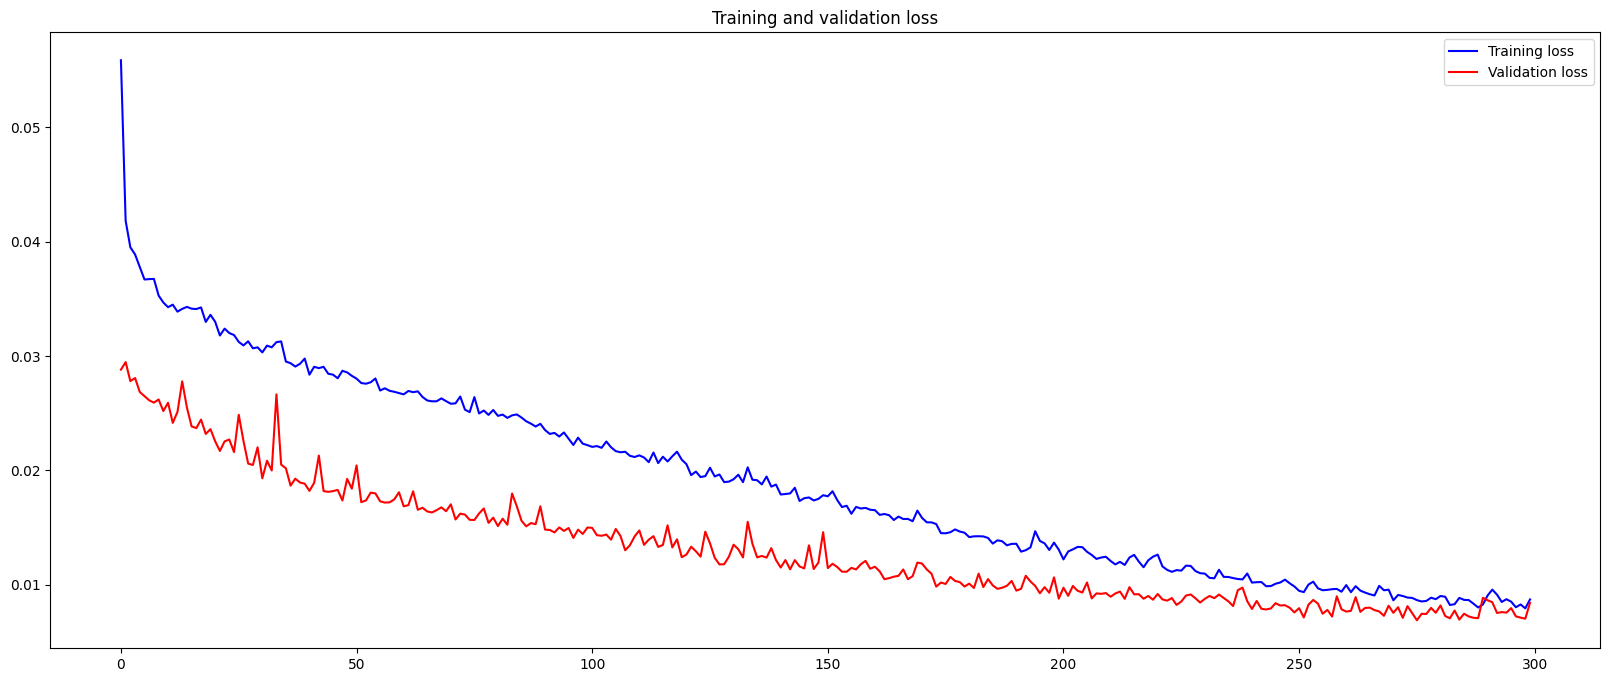

In [21]:
plot_loss(history_conv_lstm)

In [22]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

34/34 [==============================] - 2s 26ms/step


{'mae': 0.0058674095, 'mse': 9.4421484e-05, 'r2': 0.9156244993209839}

#### Plot predictions

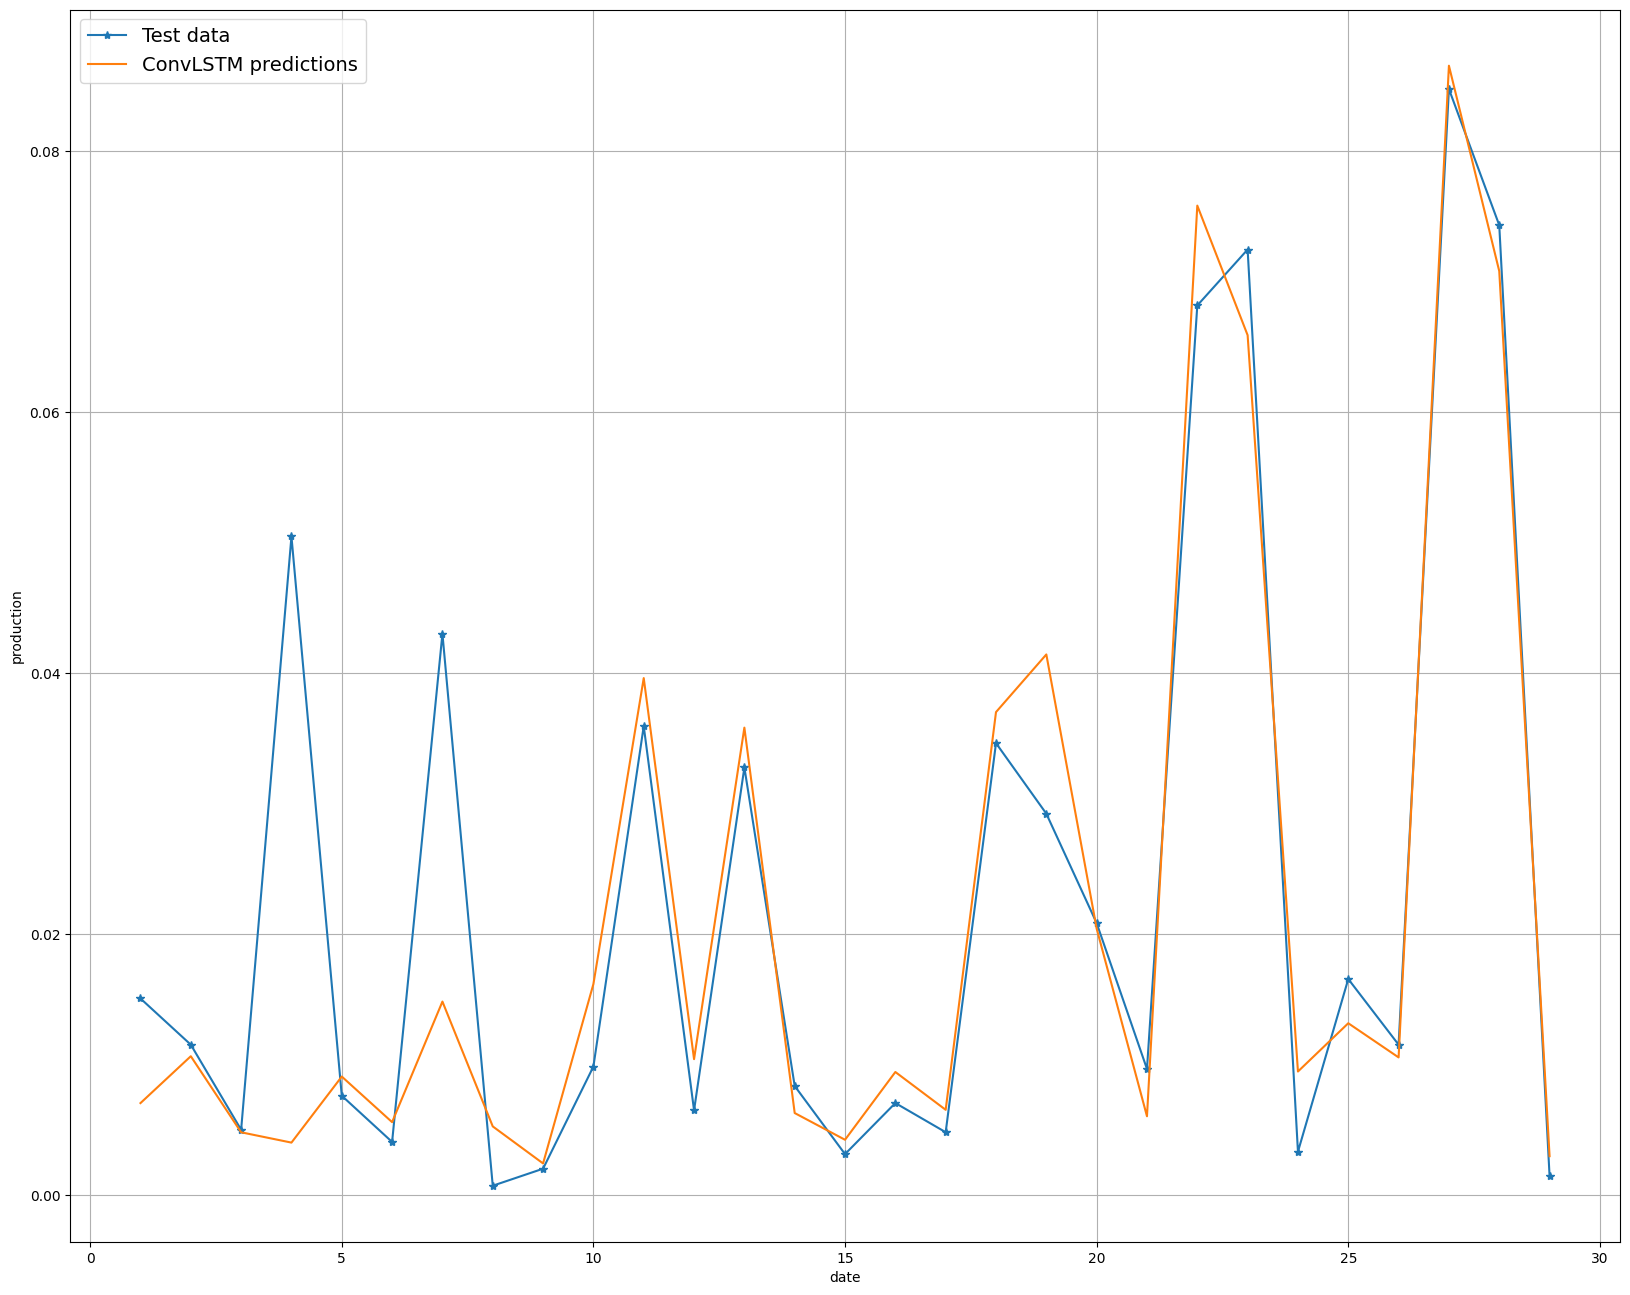

In [23]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)